## Q&A - Projects
Below you will find answers to some specific questions with regard to the projects.

### My CPU load is not maximal during a long calculation/I can only allocate one core to the CPU. Is this normal?
You might want to take a look [here](https://superuser.com/questions/823109/how-to-allocate-more-processor-power-to-my-ubuntu-based-virtualbox-system-in-w).



### Can I wait for a process to complete in SimJulia?
Below you have an illustration of a process waiting for another one to terminate before continuing.

In [1]:
using SimJulia
using Logging

@resumable function basic(sim::Simulation)
    @info "Basic goes to work on time $(now(sim))"
    p = @process bottleneck(sim)
    @yield p
    @info "Basic continues after bottleneck completion on time $(now(sim))"
end

@resumable function bottleneck(sim::Simulation)
    @yield timeout(sim, 10)
end

bottleneck (generic function with 1 method)

In [2]:
sim = Simulation()
@process basic(sim)
run(sim)

┌ Info: Basic goes to work on time 0.0
└ @ Main In[1]:5
┌ Info: Basic continues after bottleneck completion on time 10.0
└ @ Main In[1]:8


### Can I store data for later usage?
An example usage is storing the results from a set of simulations to compare this with the results with different parameters on the same figure.

You can use the [CSV](https://github.com/JuliaData/CSV.jl)  and [DataFrames](https://github.com/JuliaData/DataFrames.jl) package (you probably will need to install both). Below is a basic illustration. For most use cases, this should be sufficient. 

*Warning: you should update your filename for each run in order not the overwrite the existing data (otherwise the whole operation would be useless...)*

In [3]:
using CSV, DataFrames
using Plots

In [4]:
# points as an example
xpoints = [1,2,4,6]
ypoints = [2,3,7,7]
# store the values in a DataFrame
data = DataFrame(column1 = xpoints, column2 = ypoints)
# write the DataFrame to CSV
filename = "mydata.csv"
CSV.write(filename,data)

"mydata.csv"

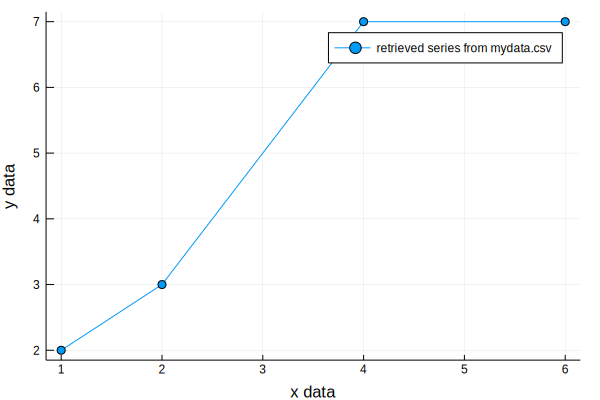

In [5]:
# read the data again:
newdf = CSV.read("mydata.csv")
plot(newdf.column1,newdf.column2,marker=:circle,label="retrieved series from $(filename)")
plot!(xlabel="x data",ylabel="y data")

### How can I bin my data and control the bin sizes?
Suppose you have some timestamped data and want to know the amount of timestamps per 2 hour window. Below is a sample application.

*Remark: for very large datasets (>1e6 elements) this might be slow. In this case you could be better of with an online implentation of a histogram using* [`OnlineStats.jl`](http://joshday.github.io/OnlineStats.jl/latest/api.html#OnlineStats.Hist) (it is unlikely that you encounter this for your project, but just in case...)

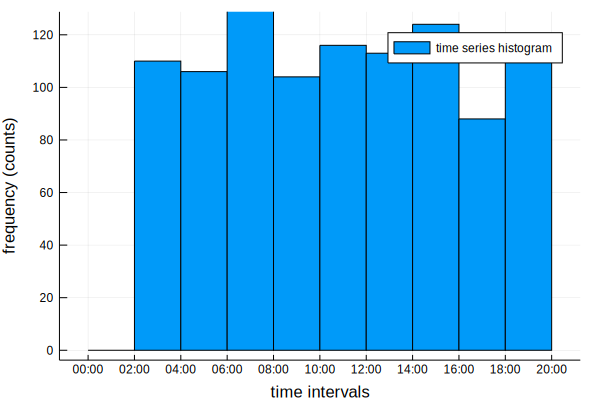

In [6]:
# required packages
using StatsBase
using Dates
using Plots
using Distributions

# generate a random sample of DateTimes
tmin = Dates.floor(Dates.now(),Day) + Hour(2)
tmax= Dates.floor(Dates.now(),Day) + Hour(20)
tarray = unix2datetime.(rand(datetime2unix(tmin) : datetime2unix(tmax),1000))
# Impose edges (we impose bins starting at 0, although there will be no observation in this bin)
limits = tmin-Hour(2):Hour(2):tmax
# make histogram (based on numerical values, not datetime representation)
h = StatsBase.fit(Histogram,Dates.value.(tarray),Dates.value.(limits),closed=:right)
plot(h,label="time series histogram")
# add appropriate xtick labels
xticks!(h.edges[1],Dates.format.(limits,"HH:MM"))
plot!(xlabel="time intervals",ylabel="frequency (counts)",ylim=[0,125])

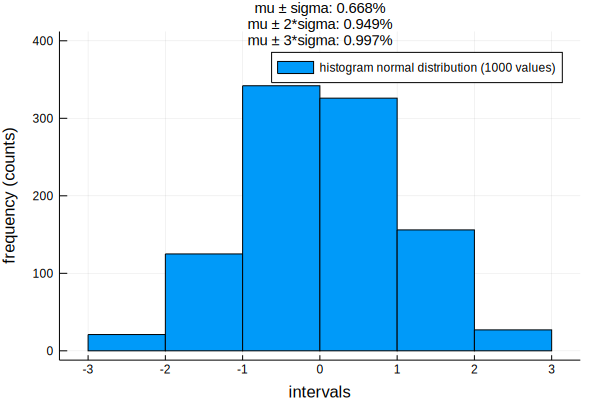

In [7]:
# the same principle but for a more familiar distribution N(0,1):
dist = Normal()
# generate a random sample
n = 1000
data = rand(dist,n)
# Impose edges:
limits = -3:1:3
# make histogram (based on numerical values, not datetime representation)
h = StatsBase.fit(Histogram,data,limits,closed=:right)
plot(h,label="histogram normal distribution ($(n) values)")
# add appropriate xtick labels
xticks!(h.edges[1])
plot!(xlabel="intervals",ylabel="frequency (counts)",figsize=(10,20))
title!("mu ± sigma: $(sum(h.weights[3:4])/n)%
        mu ± 2*sigma: $(sum(h.weights[2:5])/n)%
        mu ± 3*sigma: $(sum(h.weights[1:end])/n)%",titlefontsize=10)
plot!(ylim=[0,n*4/10])

### Can I make use of dynamicaly generated variable names?
Yes, via [metaprogramming](https://docs.julialang.org/en/v1/manual/metaprogramming/index.html). But sometimes simply using a dictionary, where the keys are dynamically generated, can be a suitable and less complicated option. Below is an illustration of both approaches for the vector $x=[1,2,\dots,10]^i + j$ with $i\in[1,2,3]$ and $j\in[0,5,10,15]$.

In [8]:
x = 0:10;

In [9]:
# using metaprogramming
for i in 1:3
    for j in 0:5:15
        varname = Symbol("x_power_$(i)_plus_$(j)")
        eval(quote 
                $varname = $(x .^i .+ j)
                println($varname) # For illustration purpose, production code would not have this println
                end)
    end
end


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
[5, 6, 9, 14, 21, 30, 41, 54, 69, 86, 105]
[10, 11, 14, 19, 26, 35, 46, 59, 74, 91, 110]
[15, 16, 19, 24, 31, 40, 51, 64, 79, 96, 115]
[0, 1, 8, 27, 64, 125, 216, 343, 512, 729, 1000]
[5, 6, 13, 32, 69, 130, 221, 348, 517, 734, 1005]
[10, 11, 18, 37, 74, 135, 226, 353, 522, 739, 1010]
[15, 16, 23, 42, 79, 140, 231, 358, 527, 744, 1015]


In [10]:
# using a dictionary
d = Dict()
for i in 1:3
    for j in 0:5:15
        d["x_power_$(i)_plus_$(j)"] = x.^i .+ j
    end
end
d

Dict{Any,Any} with 12 entries:
  "x_power_1_plus_0"  => [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "x_power_2_plus_10" => [10, 11, 14, 19, 26, 35, 46, 59, 74, 91, 110]
  "x_power_1_plus_5"  => [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  "x_power_1_plus_15" => [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
  "x_power_3_plus_10" => [10, 11, 18, 37, 74, 135, 226, 353, 522, 739, 1010]
  "x_power_1_plus_10" => [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
  "x_power_3_plus_0"  => [0, 1, 8, 27, 64, 125, 216, 343, 512, 729, 1000]
  "x_power_3_plus_5"  => [5, 6, 13, 32, 69, 130, 221, 348, 517, 734, 1005]
  "x_power_2_plus_0"  => [0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
  "x_power_2_plus_15" => [15, 16, 19, 24, 31, 40, 51, 64, 79, 96, 115]
  "x_power_2_plus_5"  => [5, 6, 9, 14, 21, 30, 41, 54, 69, 86, 105]
  "x_power_3_plus_15" => [15, 16, 23, 42, 79, 140, 231, 358, 527, 744, 1015]